In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pylab as plt
import IPython.display as ipd

import os
import numpy as np
import torch
from models import Generator, Discriminator
from layers import TacotronSTFT
from audio_processing import griffin_lim
from utils import load_wav_to_torch
from plotting_utils import reshape_to_matrix

MAX_WAV_VALUE = 32768.0
BATCH_SIZE = 32
SAMPLING_RATE = 16000
SPEAKER_ID = 101

In [2]:
torch.no_grad()

In [3]:
def load_checkpoint(checkpoint_path, D_net, G_ner):
    assert os.path.isfile(checkpoint_path)
    print("Loading checkpoint '{}'".format(checkpoint_path))
    checkpoint_dict = torch.load(checkpoint_path, map_location='cpu')
    D_net.load_state_dict(checkpoint_dict['D_net'])
    G_net.load_state_dict(checkpoint_dict['G_net'])
    print("Loaded checkpoint '{}'" .format(checkpoint_path))
    return D_net, G_net

In [4]:
def mel2spectrogram(mel, stft, C=1e4, spec_from_mel_scaling=1000):
    mel_decompress = stft.spectral_de_normalize(mel.unsqueeze(0))
    mel_decompress = mel_decompress / C
    mel_decompress = mel_decompress.transpose(1, 2).data.cpu()
    spec_from_mel = torch.mm(mel_decompress[0], taco_stft.mel_basis)
    spec_from_mel = spec_from_mel.transpose(0, 1).unsqueeze(0)
    return spec_from_mel

In [5]:
taco_stft = TacotronSTFT(
    filter_length=1024, hop_length=160,
    win_length=1024, sampling_rate=16000, n_mel_channels=64,
    mel_fmin=0, mel_fmax=None, representation='asrgen')

In [6]:
G_net = Generator(64)
D_net = Discriminator(64)

In [7]:
checkpoint_path = 'checkpoint_dcgan_speaker100_beta1.0_clr0.0001_glr0.0001_40000'

In [8]:
D_net, G_net = load_checkpoint(checkpoint_path, D_net, G_net)

Loading checkpoint 'checkpoint_dcgan_speaker100_beta1.0_clr0.0001_glr0.0001_40000'
Loaded checkpoint 'checkpoint_dcgan_speaker100_beta1.0_clr0.0001_glr0.0001_40000'


In [9]:
noise = torch.autograd.Variable(torch.randn(BATCH_SIZE, 128), volatile=True)

In [10]:
samples = G_net(noise)

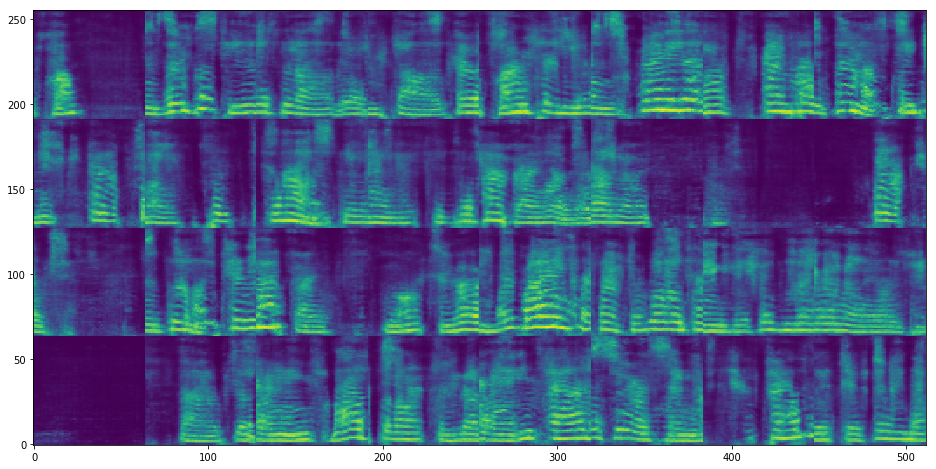

In [11]:
samples_reshape = reshape_to_matrix(samples.data.cpu().numpy(), 4, 8)
fig, ax = plt.subplots(1, 1, figsize=(16, 8))
ax.imshow(samples_reshape, origin='bottom', aspect='auto')

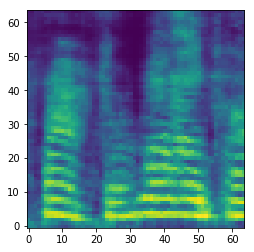

In [12]:
mel = samples[13]
plt.imshow(mel.data.cpu().numpy(), origin='bottom')

In [13]:
# scale to the range of a real mel
audio = load_wav_to_torch('data_16khz/zcathy/cathy.wav', SAMPLING_RATE)
audio /= MAX_WAV_VALUE
audio = audio[None, :]
reference_mel = taco_stft.mel_spectrogram(audio)[0]
print(reference_mel.min(), reference_mel.max())

(tensor(1.00000e-03 *
       3.5432), tensor(9.0744))


In [14]:
mel -= mel.min()
mel = mel / mel.max()
mel = mel * reference_mel.max()
print(mel.min(), mel.max())

(tensor(0.), tensor(9.0744))


In [15]:
rand_start = np.random.randint(reference_mel.size(-1) - 64)
reference_mel_patch = reference_mel[:, rand_start:rand_start+64].cpu()

In [16]:
C = 1e4
spec_from_mel = mel2spectrogram(mel, taco_stft, C)
spec_from_mel_ref = mel2spectrogram(reference_mel_patch, taco_stft, C)

/Users/rafaelvalle/Environments/dl_python2.7/lib/python2.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/rafaelvalle/Environments/dl_python2.7/lib/python2.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log
  """


Text(0.5,1,'Real Spectrogram')

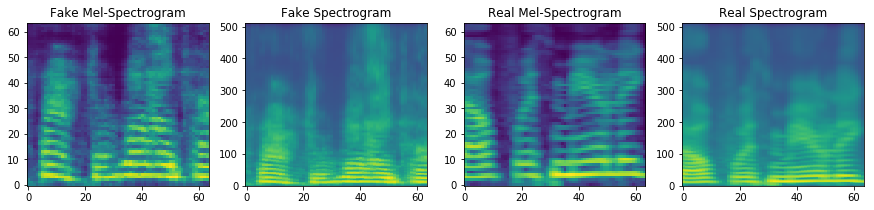

In [17]:
fig, axes = plt.subplots(1, 4, figsize=(15, 3))
axes[0].imshow(mel.data.cpu().numpy(), aspect='auto', origin='bottom', interpolation='none')
axes[1].imshow(np.log(spec_from_mel[0].numpy()), aspect='auto', origin='bottom', interpolation='none')
axes[2].imshow(reference_mel_patch.numpy(), aspect='auto', origin='bottom', interpolation='none')
axes[3].imshow(np.log(spec_from_mel_ref[0].numpy()), aspect='auto', origin='bottom', interpolation='none')
axes[0].set_title("Fake Mel-Spectrogram")
axes[1].set_title("Fake Spectrogram")
axes[2].set_title("Real Mel-Spectrogram")
axes[3].set_title("Real Spectrogram")

In [18]:
# Fake Griffin-Lim synthesis
waveform = griffin_lim(torch.autograd.Variable(spec_from_mel[:, :, :-1]), taco_stft.stft_fn, 30)
waveform = waveform / waveform.abs().max()
ipd.Audio(waveform[0].data.cpu().numpy(), rate=SAMPLING_RATE) 

In [19]:
# Real Griffin-Lim synthesis
waveform_ref = griffin_lim(torch.autograd.Variable(spec_from_mel_ref[:, :, :-1]), taco_stft.stft_fn, 30)
ipd.Audio(waveform_ref[0].data.cpu().numpy(), rate=SAMPLING_RATE) 